In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

## Data

In [2]:
class Dataset(Dataset):
    def __init__(self, features_file, label_file):
        features = pd.read_csv(features_file)
        labels = pd.read_csv(label_file)
        
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        tensor_features = torch.tensor(self.features.iloc[idx].values, dtype=torch.float)
        tensor_labels = torch.tensor(self.labels.iloc[idx].values, dtype=torch.float)

        return tensor_features, tensor_labels

In [3]:
dataset = Dataset('H1_AI_Dataset/H1_Features_Wh_12h.csv', 'H1_AI_Dataset/H1_Labels_Wh_12h.csv')
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [4]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## MLP

In [53]:
class MLP(nn.Module):
    def __init__(self, input_size=48, output_size=6, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.ln1 = nn.LayerNorm(128)
        self.dropout1 = nn.Dropout(dropout_rate)

        
        self.fc2 = nn.Linear(128, 64)
        self.ln2 = nn.LayerNorm(64)
        self.dropout2 = nn.Dropout(dropout_rate)

        
        self.fc4 = nn.Linear(64, output_size)

        self.init_weights()

    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(self.ln1(x), negative_slope=0.05)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = F.leaky_relu(self.ln2(x), negative_slope=0.05)
        x = self.dropout2(x)
        
        x = self.fc4(x)
        return x

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0)

In [54]:
# Instantiate the model, optimizer, and loss function
model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_function = nn.SmoothL1Loss()

In [55]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MLP(
  (fc1): Linear(in_features=48, out_features=128, bias=True)
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc4): Linear(in_features=64, out_features=6, bias=True)
)

In [56]:
# Training loop

train_losses = []
test_losses = []


num_epochs = 40
for epoch in range(num_epochs):

    
    model.train()  # Set the model to training mode
    total_loss = 0
    for batch_idx, (data, targets) in enumerate(train_dataloader):
        data, targets = data.to(device), targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = loss_function(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        total_loss += loss.item()


    train_loss = total_loss/len(train_dataloader)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss/len(train_dataloader):.4f}')

    

    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0
    with torch.no_grad():  # No need to track gradients for validation data
        for batch_idx, (data, targets) in enumerate(test_dataloader):
            data, targets = data.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(data)
            loss = loss_function(outputs, targets)
            
            total_test_loss += loss.item()


    test_loss = total_test_loss/len(test_dataloader)
    test_losses.append(test_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {total_test_loss/len(test_dataloader):.4f}')

Epoch [1/40], Training Loss: 8.5934
Epoch [1/40], Test Loss: 8.2595
Epoch [2/40], Training Loss: 7.9834
Epoch [2/40], Test Loss: 7.6990
Epoch [3/40], Training Loss: 7.6120
Epoch [3/40], Test Loss: 7.4283
Epoch [4/40], Training Loss: 7.4227
Epoch [4/40], Test Loss: 7.3232
Epoch [5/40], Training Loss: 7.3651
Epoch [5/40], Test Loss: 7.2188
Epoch [6/40], Training Loss: 7.2875
Epoch [6/40], Test Loss: 7.2195
Epoch [7/40], Training Loss: 7.2428
Epoch [7/40], Test Loss: 7.2002
Epoch [8/40], Training Loss: 7.1908
Epoch [8/40], Test Loss: 7.0872
Epoch [9/40], Training Loss: 7.1485
Epoch [9/40], Test Loss: 7.0605
Epoch [10/40], Training Loss: 7.1196
Epoch [10/40], Test Loss: 7.0606
Epoch [11/40], Training Loss: 7.0959
Epoch [11/40], Test Loss: 6.9960
Epoch [12/40], Training Loss: 7.0467
Epoch [12/40], Test Loss: 6.9748
Epoch [13/40], Training Loss: 7.0176
Epoch [13/40], Test Loss: 6.9785
Epoch [14/40], Training Loss: 6.9852
Epoch [14/40], Test Loss: 7.0081
Epoch [15/40], Training Loss: 6.9923
E

## Below shows mean values for each column & total mean value in Labels
* This is done to get an idea of the loss function
* The loss is the average loss per sample/row

In [40]:
total_sum = torch.zeros(6)  # Assuming there are 6 columns in your labels
total_count = 0

for _, labels in dataloader:
    total_sum += labels.sum(dim=0)  # Sum each column across the batch
    total_count += labels.size(0)  # Count the number of samples (rows)

column_means = total_sum / total_count
print("Column-wise mean values of labels:", column_means)

sample_total_means = column_means.sum()
print("Sample average total value:", sample_total_means)

total_mean = column_means.sum() / column_means.numel()
print("Scalar total mean of labels:", total_mean)

Column-wise mean values of labels: tensor([ 9.4314,  7.4385, 16.7290, 22.3034,  4.6413,  6.2054])
Sample average total value: tensor(66.7489)
Scalar total mean of labels: tensor(11.1248)


## Plotting graph of learning rate

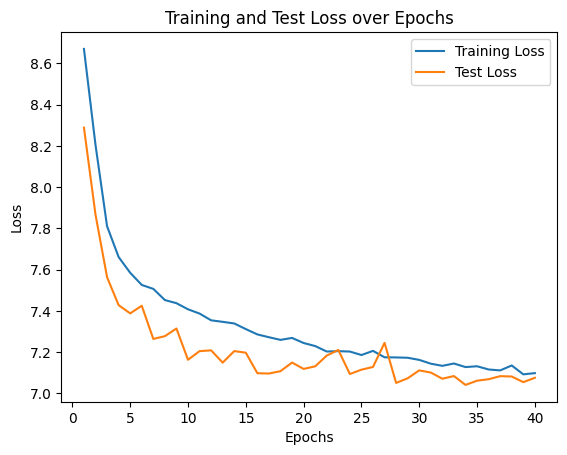

In [41]:
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.show()